# Performance Management(パフォーマンス管理): Q-CTRL Fire Opal による Qiskit Function 

<Admonition type="note">
  Qiskit Functionsは、IBM Quantum™ Premium Plan ユーザーのみが利用できる実験的な機能です。プレビュー リリースの状態であり、変更される可能性があります。 
</Admonition>

## Overview

Fire Opal Performance Management を使用すると、量子ハードウェアの専門家でなくても、誰でも大規模な量子コンピューターから意味のある結果を簡単に得ることができます。Fire Opal Performance Management を使用して回路を実行すると、このfunction が AI 駆動のエラー抑制技術を自動的に適用し、デバイス上のゲートと量子ビットをさらに使用して、より大きな問題に正常にスケーリングします。同時に、正しい答えに到達するのに必要な試行回数が少なくなり、オーバーヘッドが不要になるため、計算時間とコストを節約できます。

Performance Management はエラーを抑制し、ノイズの多いハードウェアで正しい答えを得る可能性を高めます。つまり、信号対雑音比を高めます。次の図は、パフォーマンス管理によって精度が向上し、10 量子ビットの量子フーリエ変換アルゴリズムの場合に追加ショットの必要性が減る様子を示しています。Q-CTRL はわずか 30 ショットで 99% の信頼しきい値に達しますが、デフォルト (`QiskitRuntime` Sampler、`optimization_level`=3  および`resilience_level`=1, `ibm_sherbrooke`) では 170,000 ショットが必要です。正しい答えをより早く得ることで、コンピューティング実行時間を大幅に節約できます。

![Visualization of the improved runtime](./images/guides/qctrl-performance-management/achieve_more.svg)

Performance Management function は、標準の[Qiskit Runtime primitives](./primitives)の代わりに使用できます。バックグラウンドでは、複数のエラー抑制技術が連携して動作し、実行時にエラーが発生するのを防ぎます。Fire Opal パイプライン メソッドはすべて事前に構成されており、アルゴリズムに依存しないため、すぐに最高のパフォーマンスを常に得ることができます。

Performance Managementにアクセスするには、[contact Q-CTRL](https://form.typeform.com/to/JKHcaxlv?typeform-source=q-ctrl.com#product=Fire%20Opal) にお問い合わせください。



# 機能説明
Fire Opal Performance Managemenには、Qiskit Runtime primitivesに似た実行オプションが 2 つあるため、Q-CTRL SamplerとEstimatorを簡単に入れ替えることができます。Performance Managemen Functionを使用するための一般的なワークフローは次のとおりです。

1. 回路 (および Estimator の場合は演算子) を定義します。
2. 回路を走らせます。
3. 結果を取得します。
   
ハードウェア ノイズを低減するために、Fire Opal では、次の図に示すような AI 駆動型のさまざまなエラー抑制技術を採用しています。エラー抑制はゲート レベルとパルス レベルの両方で機能し、さまざまなノイズ源に対処して、エラーが発生する可能性を防ぎます。Fire Opal を使用すると、パイプライン全体が完全に自動化され、構成は一切必要ありません。エラーを防止することで、コストのかかる後処理が不要になります。

次の図は、Fire Opal Performance Management によって自動化されたエラー抑制方法を示しています。

![Visualization of the error suppression pipeline](./images/guides/qctrl-performance-management/error_suppression.svg)

## 入力と出力

Sampler および Estimator の入力は、[Qiskit Runtime V2 primitives](../migration-guides/v2-primitives) の実装仕様に厳密に従っています。Q-CTRL primitives は、回路とそれに関連する実行データを含むタプルである Primitive Unified Blocs (PUB) の形式で入力を受け入れます。PUB データ構造の詳細については、[IBM Quantum Documentation](./primitive-input-output)を参照してください。主な違いは、Q-CTRL primitivesが、QASM 文字列、辞書などの基本型を含む PUB を受け入れるという点です。

<Admonition type="caution">Fire Opal Performance Management は、ターゲット バックエンドの命令セット アーキテクチャ (ISA) で記述された回路のみを受け入れる元々の Qiskit Runtime primitivesとは対照的に、抽象回路を受け入れます。最良の結果を得るには、Performance Management function を使用して送信する前に回路をトランスパイルしないでください。</Admonition>

### Samplerの入力

| Name       | Type                                          | Description                                                                                                 | Required | Example                                                                                                             |
|------------|-----------------------------------------------|-------------------------------------------------------------------------------------------------------------|----------|---------------------------------------------------------------------------------------------------------------------|
| pubs       | `SamplerPubLike` or `list[SamplerPubLike]`   | One or more tuples containing the inputs listed under `SamplerPubLike` components.                          | Yes      | `(circuit, parameter_values)`                                                                                |
| instance   | str                                           | The hub/group/project to use in that format.                                                               | Yes      | `"hub1/group1/project1"`                                                                                           |
| run\_options| dict                                          | Input options which includes the following: (Optional) `backend_name`: str, `shots`: int. Defaults to least busy backend and 4000 shots. | No       | `{"backend_name": backend_name, "shots": 2048}`                                                                   |

**`SamplerPubLike` components:**

*   OpenQASM 2.0 または 3.0 文字列形式の単一回路。
*   (オプション) 回路をバインドするパラメータ値のコレクション。
*   (オプション) ショット数などの実行オプションの辞書。

### Samplerの出力

| Name   | Type                                   | Description                                                                               | Example                         |
|--------|----------------------------------------|-------------------------------------------------------------------------------------------|---------------------------------|
| result | `list[ArrayLike[dict[str, int]]]`      | 入力PUBのリストに対応するカウントの辞書の結果リスト。       | `[{'000001': 100, '000011': 2}]` |

### Estimatorの入力

| Name       | Type                                          | Description                                                                                                 | Required | Example                                                                                                             |
|------------|-----------------------------------------------|-------------------------------------------------------------------------------------------------------------|----------|---------------------------------------------------------------------------------------------------------------------|
| pubs       | `EstimatorPubLike` or `list[EstimatorPubLike]` | One or more tuples containing the inputs listed under `EstimatorPubLike` components.                          | Yes      | `(circuit, observables, parameter_values)`                                                                                  |
| instance   | str                                           | The hub/group/project to use in that format.                                                               | Yes      | `"hub1/group1/project1"`                                                                                           |
| run\_options| dict                                          | Input options which includes the following: (Optional) `backend_name`: str, `shots`: int. Defaults to least busy backend and 4000 shots. | No       | `{"backend_name": backend_name, "shots": 2048}`                                                                   |

**`EstimatorPubLike` components:**

*   OpenQASM 2.0 または 3.0 文字列形式の単一回路。
*   「受け入れられるオブザーバブルの形式」リストに示されているいずれかの形式で、推定する期待値を指定する 1 つ以上のオブバーバブル。
*   (オプション) 回路をバインドするパラメータ値のコレクション。
*   (オプション) ショット数などの実行オプションの辞書。

**受け入れられるオブザーバブルの形式:**

*   A Pauli string: `"XY"`

*   辞書 ー 係数付きのPauli strings: `{"XY": 0.5, "YZ": 0.3}`

*   Pauli stringsのリスト: `["XY", "YZ", "ZX"]`

*   係数付きのPauli stringsのリスト: `[("XY", 0.5), ("YZ", 0.3)]`

*   Pauli stringsのネストされたリスト: `[["XY", "YZ"], ["ZX", "XX"]]`

*   係数を持つパウリ文字列のネストされたリスト: `[[("XY", 0.1), ("YZ", 0.2)], [("ZX", 0.3), ("XX", 0.4)]]`

### Estimatorの出力

| Name   | Type                            | Description                                                                                      | Example             |
|--------|---------------------------------|--------------------------------------------------------------------------------------------------|---------------------|
| values | `valueslist[ArrayLike[float]]`  | 入力 PUB のリストに対応する期待値の結果リスト.               | `[0.43046065915270004]` |

### Parameter 形式
Sampler and Estimator は両方とも、`QiskitRuntime` primitivesと同じ[配列ブロードキャスト ルール](./primitive-input-output#broadcasting-rules)に従うパラメーターを受け入れます。次のパラメーター形式が受け入れられます:

| Format                                      | Example                                                                                           |
|---------------------------------------------|---------------------------------------------------------------------------------------------------|
| 0-d array (single binding)                  | `{"a": 4, ("b", "c"): [5, 6]}`                                                                    |
| Single array (last index for parameters)    | `{"a[0]", "a[1]", "a[2]": [0.1, 0.2, 0.3]}`                                                     |
| Multiple arrays (last index for parameters, flexible dimensions) | `{"c": np.ones((10, 10, 2)).tolist(), "b": np.zeros((10, 10)).tolist()}`                       |


## ベンチマーク
[公開されたアルゴリズムのベンチマーク](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.20.024034)結果では、Bernstein-Vazirani、量子フーリエ変換、Grover 探索、QAOA(量子近似最適化アルゴリズム)、VQE(変分量子固有値ソルバー)など、さまざまなアルゴリズムで大幅なパフォーマンスの向上が実証されています。このセクションの残りの部分では、実行できるアルゴリズムの種類、および予想されるパフォーマンスと実行時間について詳しく説明します。

以下の独立した研究は、Q-CTRL のPerformance Managementが記録的な規模でアルゴリズム研究を可能にする方法を実証しています。

*   [ネットワークサービス障害診断のためのパラメータ化されたエネルギー効率の高い量子カーネル](https://arxiv.org/abs/2405.09724v1)- 最大 50 量子ビットの量子カーネル学習
*   [大規模デモンストレーションのためのテンソルベースの量子位相差推定](https://arxiv.org/abs/2405.09724v1)- 最大 33 量子ビットの量子位相推定
*   [量子機械学習のための階層的学習: 大規模変分量子回路の新しいトレーニング手法](https://arxiv.org/abs/2311.12929) - 最大 21 量子ビットの量子データ読み込み

次の表は、 `ibm_fez` での以前のベンチマーク実行からの精度と実行時間に関する大まかなガイドを示しています。他のデバイスではパフォーマンスが異なる場合があります。使用時間は、回路あたり 10,000 ショットの想定に基づいています。示されている「量子ビットの数」は厳密な制限ではありませんが、非常に一貫したソリューション精度を期待できる大まかなしきい値を表しています。より大きなサイズの問題が正常に解決されており、これらの制限を超えてテストすることをお勧めします。

| Example    | Number of qubits | Accuracy | Measure of accuracy | Total time (s) | Runtime usage (s) | Primitive (Mode) |
| ---------  | ---------------- | -------------------------- | -------- | ---------- | ------------- |------------- |
| Bernstein–Vazirani  |  50Q    | 100%  | Success Rate (Percentage of runs where the correct answer is the highest count bitstring)     | 10    | 8         | Sampler |
| Quantum Fourier Transform | 30Q              | 100% | Success Rate (Percentage of runs where the correct answer is the highest count bitstring)      | 10    | 8        | Sampler |
| Quantum Phase Estimation  | 30Q   | 99.9998%  | Accuracy of the angle found: `1- abs(real_angle - angle_found)/pi`  | 10  | 8  | Sampler |
| Quantum simulation: Ising model (15 steps) | 20Q  | 99.775%   |  $A$ (defined below)  |  60 (per step)  | 15 (per step)   | Estimator |
| Quantum simulation 2: molecular dynamics (20 time points) | 34Q  |  96.78%  |  $A_{mean}$ (defined below)   | 10 (per time point)    | 6 (per time point)  | Estimator |

期待値の測定の精度を定義する - メトリック $A$ は次のように定義されます


$$A = 1 - \frac{|\epsilon^{ideal} - \epsilon^{meas}|}{\epsilon^{ideal}_{max} - \epsilon^{ideal}_{min}},$$


ここで、$\epsilon^{ideal}$ = 理想的な期待値、$\epsilon^{meas}$ = 測定された期待値、$\epsilon^{ideal}_{max} $ = 理想的な最大値、$\epsilon^{ideal}_{min}$ = 理想的な最小値です。$A_{mean}$ は、複数の測定にわたる $A$ の値の平均です。

このメトリックが使用されるのは、達成可能な値の範囲におけるグローバル シフトとスケーリングに対して不変であるためです。言い換えると、期待値のとりうる範囲を高くしたり低くしたり、スプレッドを大きくしたりしても、$A$ の値は一定のままであるはずです。



## 始めてみましょう
 [IBM Quantum Platform API token](http://quantum.ibm.com/)を使用して認証し、次のように Qiskit 関数を選択します。

In [ ]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog

# Credentials
token = "<YOUR_IQP_API_TOKEN>"
hub = "<YOUR_IQP_HUB>"
group = "<YOUR_IQP_GROUP>"
project = "<YOUR_IQP_PROJECT>"

# Authentication
catalog = QiskitFunctionsCatalog(token=token)

# Access Function
perf_mgmt = catalog.load("q-ctrl/performance-management")

## 例: Sampler

Fire Opal Performance Management のSamplerモードを使用して、Bernstein–Vazirani 回路を実行します。このアルゴリズムは、ブラック ボックス関数の出力から隠された文字列を見つけるために使用され、正解が 1 つしかないため、一般的なベンチマーク アルゴリズムです。


### 1. 回路を作成する
アルゴリズムの正しい答え、隠しビット文字列、および Bernstein-Vazirani 回路を定義します。 `circuit_width` を変更するだけで回路の幅を調整できます。


In [2]:
import qiskit

circuit_width = 35
hidden_bitstring = "1" * circuit_width

# Create circuit, reserving one qubit for BV oracle
bv_circuit = qiskit.QuantumCircuit(circuit_width + 1, circuit_width)
bv_circuit.x(circuit_width)
bv_circuit.h(range(circuit_width + 1))
for input_qubit, bit in enumerate(reversed(hidden_bitstring)):
    if bit == "1":
        bv_circuit.cx(input_qubit, circuit_width)
bv_circuit.barrier()
bv_circuit.h(range(circuit_width + 1))
bv_circuit.barrier()
for input_qubit in range(circuit_width):
    bv_circuit.measure(input_qubit, input_qubit)

# Create PUB tuple
pubs = [(bv_circuit,)]

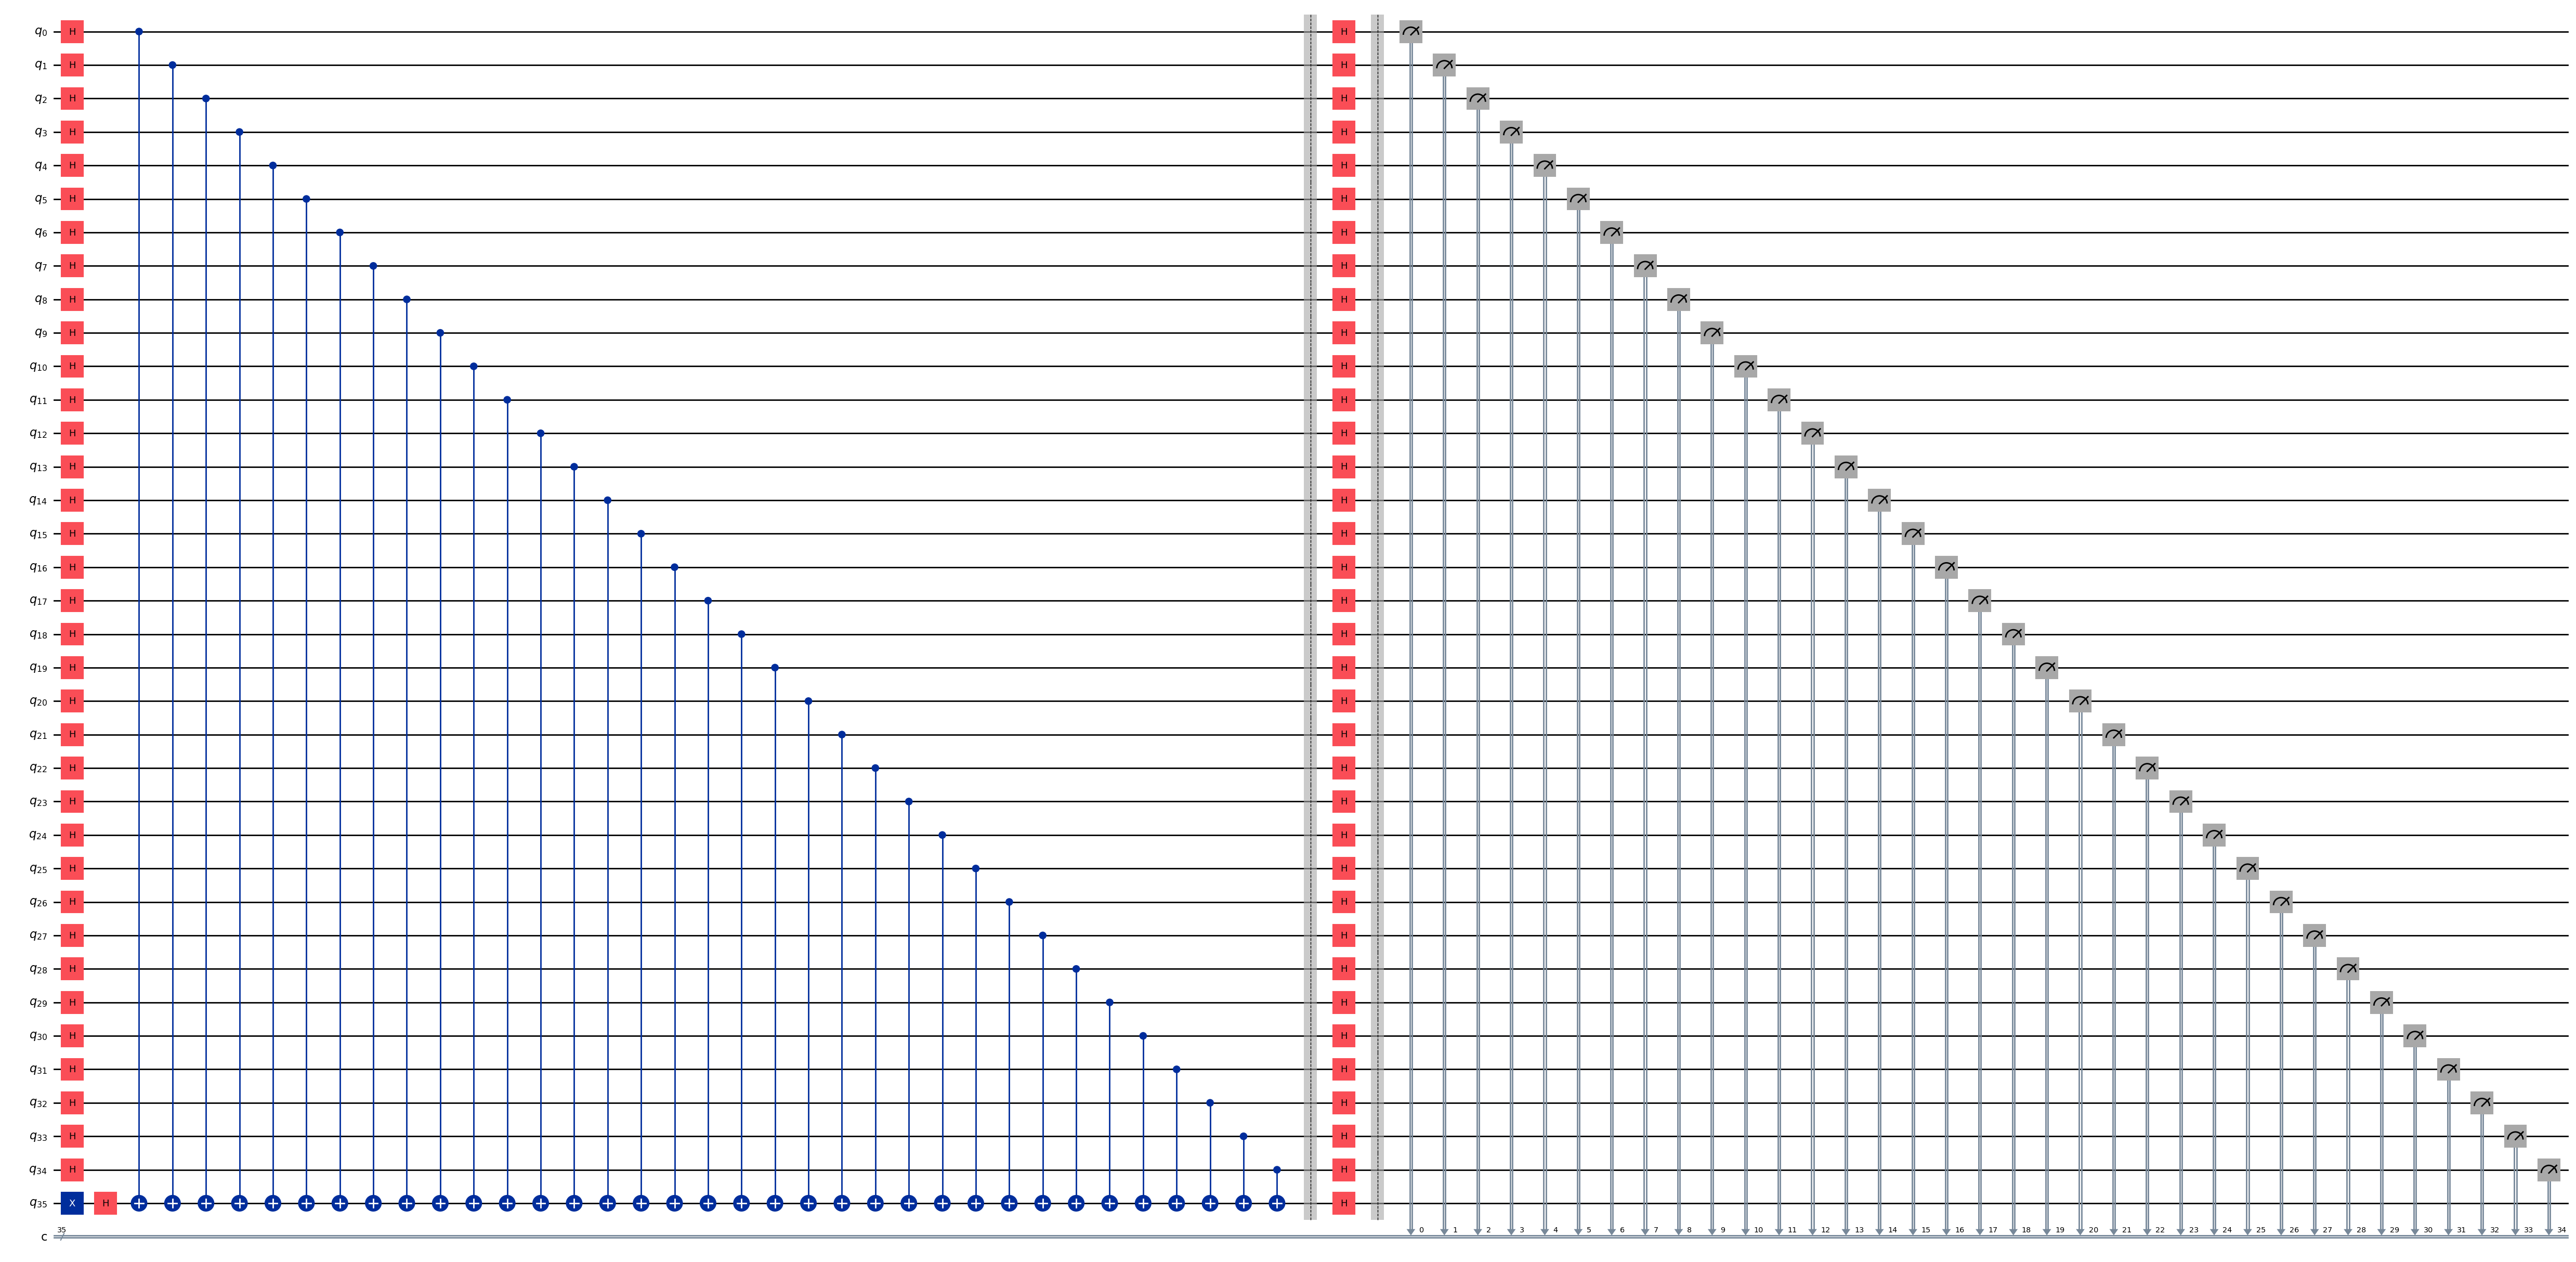

In [4]:
bv_circuit.draw("mpl", fold=1)

### 2. Run the circuit

回路を実行し、必要に応じてバックエンドとショット数を定義します。

In [ ]:
# Choose a backend or remove this option to default to the least busy device
backend_name = "<CHOOSE_A_BACKEND>"

# Run the circuit using the sampler
qctrl_sampler_job = perf_mgmt.run(
    runner_function ="sampler",
    pubs = pubs,
    instance = hub + "/" + group + "/" + project,
    run_options = {"backend_name": backend_name},
)

使い慣れた[Qiskit Serverless APIs](./serverless) を使用して、Qiskit Function ワークロードのステータスを確認できます。

In [ ]:
print(qctrl_sampler_job.status())

### 3. Retrieve the result


In [ ]:
# Retrieve the counts from the result list
counts = qctrl_sampler_job.result()[0]

後で結果を取得する必要がある場合は、次のセルを実行してジョブ ID を保存できます。

In [ ]:
qctrl_sampler_job_id = qctrl_sampler_job.job_id
print(qctrl_sampler_job_id)

ジョブ ID を使用してジョブ オブジェクトを取得し、ステータスや結果を取得できます。

In [ ]:
qctrl_sampler_job = catalog.get_job_by_id(qctrl_sampler_job_id)

## 例: Estimator

Fire Opal Performance Managementのサンプラー モードを使用して、Bernstein–Vazirani 回路を実行します。このアルゴリズムは、ブラック ボックス関数の出力から隠された文字列を見つけるために使用され、正解が 1 つしかないため、一般的なベンチマーク アルゴリズムです。


 `qiskit-ibm-catalog` と `qiskit` パッケージに加えて、このサンプルを実行するには `NumPy` パッケージも使用します。IPythonカーネルを使用してこのサンプルをノートブックで実行する場合、以下のセルをアンコメントすることでこのパッケージをインストールすることができます。

In [ ]:
# %pip install numpy

### 1. Create the circuit

例として、ランダムなエルミート演算子とオブザーバブルを生成し、Performance Management functionに入力します。

In [10]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.quantum_info import random_hermitian

n_qubits = 50

# Generate a random circuit
mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
circuit.measure_all()

# Define observables as a string
observable = "Z" * n_qubits

In [11]:
# Create PUB tuple
pubs = [(circuit, observable)]

### 2. Run the circuit

回路を実行し、必要に応じてバックエンドとショット数を定義します。

In [8]:
# Choose a backend or remove this option to default to the least busy device
backend_name = "<CHOOSE_A_BACKEND>"

qctrl_estimator_job = perf_mgmt.run(
    runner_function = "estimator",
    pubs = pubs,
    instance = hub + "/" + group + "/" + project,
    run_options = {"backend_name": backend_name},
)

使い慣れた[Qiskit Serverless APIs](./serverless) を使用して、Qiskit Function ワークロードのステータスを確認できます。

In [ ]:
print(qctrl_estimator_job.status())

### 3. Retrieve the result


In [ ]:
# Retrieve the counts from the result list
expectation_value = qctrl_estimator_job.result()[0]

print(f"Expectation value: {expectation_value}")

後で結果を取得する必要がある場合は、次のセルを実行してジョブ ID を保存できます。

In [ ]:
qctrl_estimator_job_id = qctrl_estimator_job.job_id
print(qctrl_estimator_job_id)

ジョブ ID を使用してジョブ オブジェクトを取得し、ステータスや結果を取得できます。


In [ ]:
qctrl_estimator_job = catalog.get_job_by_id(qctrl_estimator_job_id)

## サポートを得る

ご質問や問題については、[Q-CTRLにコンタクトしてください。](https://form.typeform.com/to/iuujEAEI)

## 次のステップ

  *   [Q-CTRL Performance Management](https://quantum.ibm.com/functions?id=c750648c-ba44-4137-8c34-4140a3aaa7a9) へのアクセスをリクエストする
